In [34]:
# this is under construction! DON'T TRUST WHAT IT SAYS

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import re
import pickle as pkl
import pandas as pd

## Load Data

In [348]:
# data dirs
pstims_ext = './data/preceding_stims/'
rNSTs_ext = './data/resulting_NSTs/'
rPSTs_ext = './data/resulting_PSTs/'

# load pivots
pivots = pkl.load(open('./data/pivots.pkl', "rb"))
print(len(pivots))

206


In [37]:
# load data
# store data here
preceding_stims = []
rNSTs = []
rPSTs = []

for pivot_ind in list(pivots.keys()):
    pstims_file = 'pstims' + str(pivot_ind) + '.txt'
    rNSTs_file = 'rNSTs' + str(pivot_ind) + '.npy'
    rPSTs_file = 'rPSTs' + str(pivot_ind) + '.pkl'
    
    # preceding_stims
    with open(pstims_ext + pstims_file, 'r') as reader:
        data = reader.readlines()
        data = [float(s.strip()) for s in data]
        preceding_stims.append(data)
    
    # rNSTs
    rNSTs.append(np.load(rNSTs_ext + rNSTs_file))
    
    # rPSTs
    rPSTs.append(pkl.load(open(rPSTs_ext + rPSTs_file, "rb")))

# convert to numpy arrays
preceding_stims = np.array(preceding_stims)
print('preceding_stims:', preceding_stims.shape)

rNSTs = np.stack(rNSTs) # dimensions are (preceding_stims, preceding_stims (walking), histories)
rNSTs[rNSTs == 'na'] = np.nan
rNSTs = rNSTs.astype(float)
print('rNSTs:', rNSTs.shape)

print('rPSTs:', len(rPSTs))

preceding_stims: (206, 10)
rNSTs: (206, 10, 1000)
rPSTs: 206


## Visualization functions

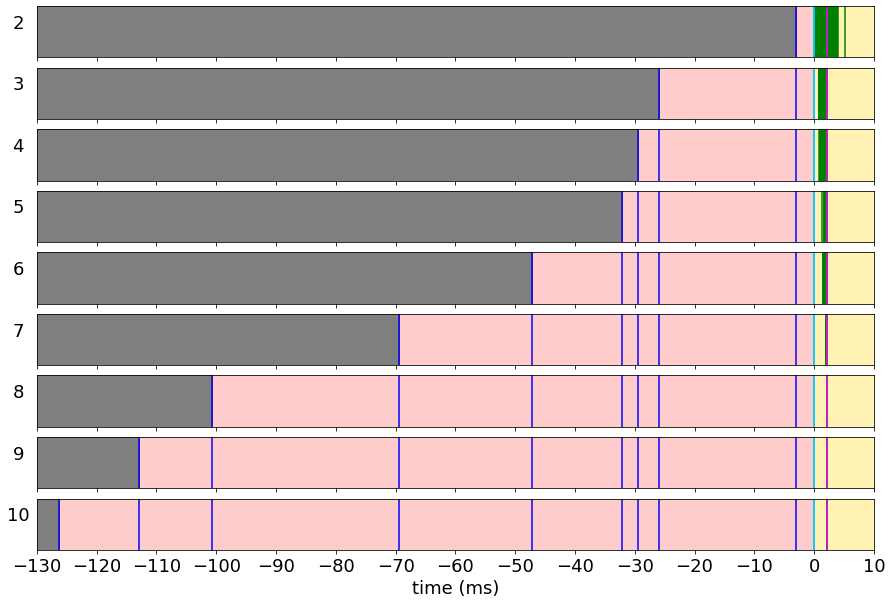

In [246]:
plt.rcParams.update({'font.size': 18})
def view_preceding_stims_walk(preceding_stims, resulting_NSTs, rPSTs, pivot):
    fig, axes = plt.subplots(len(preceding_stims) - 1,1, figsize = (15,10), sharex = True)

    # get the latest spike time to set the xlim
    latest_spike_time = np.nanmax(resulting_NSTs)

    for i in range(1, len(preceding_stims)):
        i_ax = i - 1
        # xlims
        left_buffer = 2
        axes[i_ax].set_xlim([math.floor(preceding_stims[0]) - left_buffer, latest_spike_time + 2])
        
        # uncertain history window
        left = preceding_stims[0] - left_buffer
        bottom = 0
        width = left_buffer + preceding_stims[len(preceding_stims) - 1 - i] - preceding_stims[0]
        height = 1
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left - 10,bottom), width + 10, height, color="black", alpha = 0.5)) # add anextra 10 buffer so there isn't any white space
        
        # certain history window
        left = left + width
        width = 0 - left
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="red", alpha = 0.2))
        
        # output window
        left = left + width
        width = 100
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="gold", alpha = 0.3))

        # output spikes
        axes[i_ax].vlines(resulting_NSTs[i,:], 0, 1, color = 'green')
        
        # pre-last-stimulus spikes
        #axes[i_ax].vlines(rPSTs[i], 0, 1, color = 'limegreen')

        # stimuli
        axes[i_ax].vlines(preceding_stims[-i-1:], 0, 1, color = 'blue')
        axes[i_ax].vlines(preceding_stims[-i-1:][-1], 0, 1, color = 'cyan')

        # pivot spike
        axes[i_ax].vlines(pivot, 0, 1, color = 'fuchsia')

        # set axes ticks and such
        if i != len(preceding_stims) - 1:
            axes[i_ax].set_xticks([])
        else:
            axes[i_ax].set_xlabel('time (ms)')

        axes[i_ax].set_ylabel(str(i+1) + '     ', rotation = 0)
        axes[i_ax].set_yticks([])
        
        axes[i_ax].set_ylim(.1,.2)
    last_x_tick = math.floor(preceding_stims[0]/10)*10
    axes[-1].set_xticks(range(last_x_tick,20,10))
    plt.show()
    
    return

ind = 38
view_preceding_stims_walk(preceding_stims[ind,:], rNSTs[ind,:,:], rPSTs[ind], list(pivots.values())[ind])

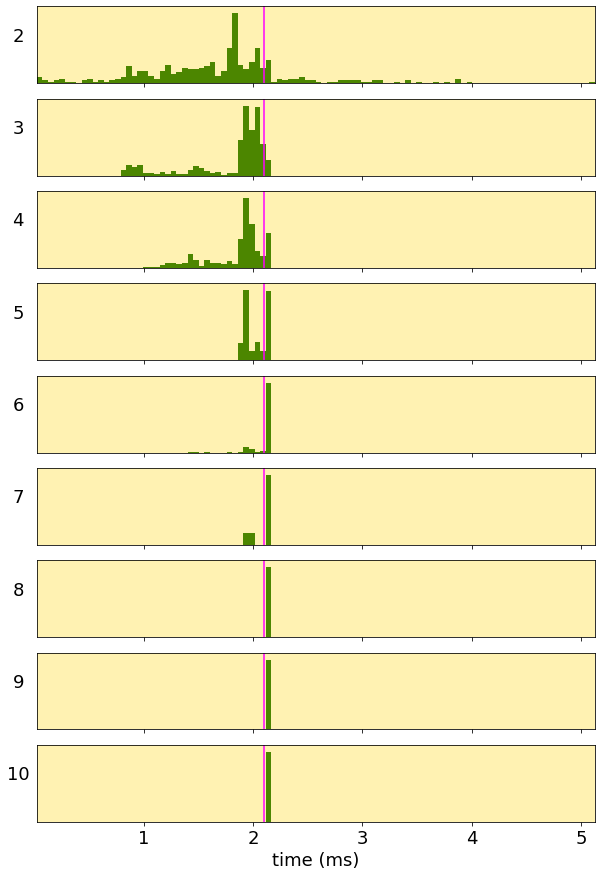

In [347]:
def view_NST_hists(preceding_stims, resulting_NSTs, pivot):
    all_resulting_NSTs = np.array([st for sts in resulting_NSTs[1:] for st in sts])
    # remove nans
    all_resulting_NSTs = all_resulting_NSTs[~np.isnan(all_resulting_NSTs)]
    
    # run histogram on all output spikes to generate the bins for the specific histograms
    #n, bins, patches = plt.hist([st for sts in resulting_NSTs[1:] for st in sts], bins = 100)
    count, bins  = np.histogram(all_resulting_NSTs, 100)

    # NST hist
    fig, axes = plt.subplots(len(preceding_stims) - 1,1, figsize = (10,15), sharex = True)

    # get the latest spike time to set the xlim
    latest_spike_time = max([st for sts in resulting_NSTs for st in sts])

    for i in range(1, len(preceding_stims)):
        i_ax = i - 1
        n, bins, patches = axes[i_ax].hist(resulting_NSTs[i], bins, color = 'darkgreen')
        axes[i_ax].vlines(pivot, -1000000, 100000, color = 'fuchsia')
        axes[i_ax].set_ylabel(str(i+1) + '     ', rotation = 0)
        axes[i_ax].set_yticks([])
        
        
        # window
        left = 0
        bottom = -1000
        width = 100
        height = 100000
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="gold", alpha = 0.3))
        axes[i_ax].set_ylim(0, max(patches.datavalues) * 1.1)
    
    axes[i_ax].set_xlim(min(bins),max(bins))
    
    axes[i_ax].set_xlabel('time (ms)')
    plt.show()
    
    return patches

ind = 38
patches = view_NST_hists(preceding_stims[ind,:], rNSTs[ind,:,:], list(pivots.values())[ind])

In [44]:
# time_determined x variance scatter plot
time_determined = []
number_determined = []
variances = []
stdevs = []
spiking_freq = []

for i in range(preceding_stims.shape[0]): # for each experiment
    current_stims = preceding_stims[i]
    for j in range(len(current_stims)): # for each walking subset of preceding_stims
        current_walking_stims = current_stims[-j-1:]
        
        # time determined
        time_determined.append(current_walking_stims[0])
        # number determined
        number_determined.append(len(current_walking_stims))
        # next spike time variation
        variances.append(np.nanvar(rNSTs[i,j,:]))
        # next spike time standard deviation
        stdevs.append(np.nanstd(rNSTs[i,j,:]))
        # frequency to spike
        spiking_freq.append(np.count_nonzero(~np.isnan(rNSTs[i,j,:])))

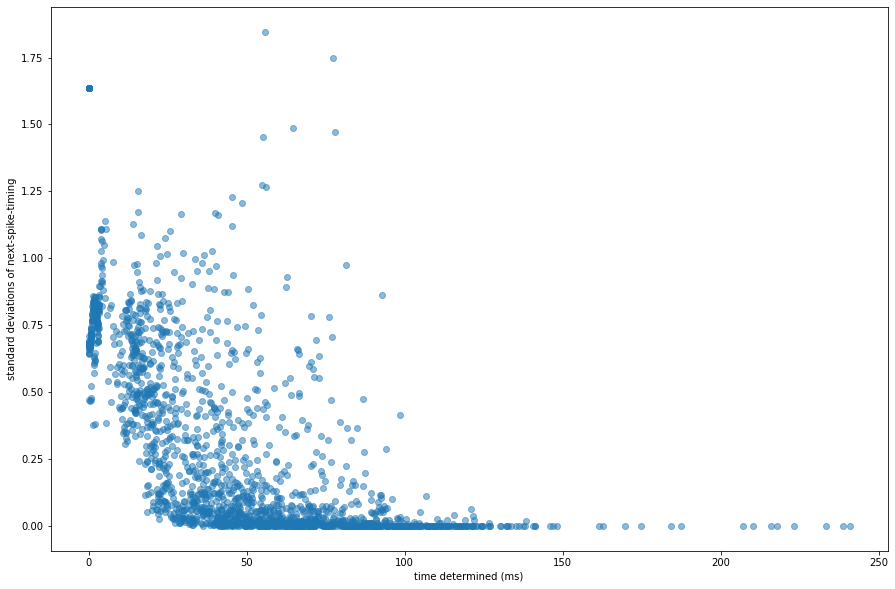

In [48]:
plt.figure(figsize = (15,10))
plt.scatter([td * -1 for td in time_determined], stdevs, alpha = 0.5)
plt.ylabel('standard deviations of next-spike-timing')
plt.xlabel('time determined (ms)')
plt.show()

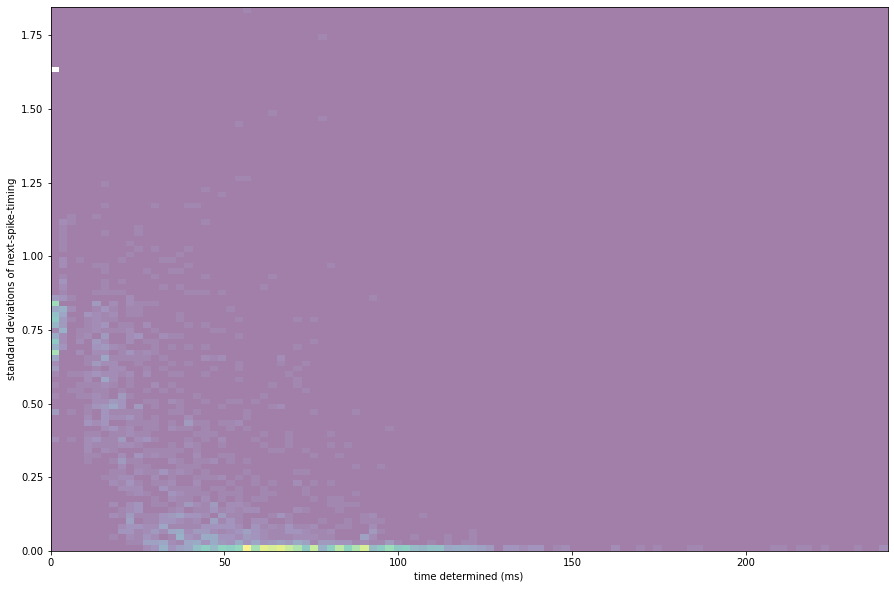

In [59]:
plt.figure(figsize = (15,10))
plt.hist2d([td * -1 for td in time_determined], stdevs, alpha = 0.5, bins = 100, cmax = 100)
plt.ylabel('standard deviations of next-spike-timing')
plt.xlabel('time determined (ms)')
plt.show()

## Isolation of individual cases

In [183]:
df = pd.DataFrame(
    (
        time_determined,
        number_determined,
        variances,
        stdevs,
        spiking_freq
    ),   
)
df = df.transpose()
df.columns = [
        'time_determined',
        'number_determined',
        'variances',
        'stdevs',
        'spiking_freq'
    ]

In [214]:
df

,time_determined,number_determined,variances,stdevs,spiking_freq
0,0.00,1.0,2.682263e+00,1.637762e+00,291.0
1,-0.65,2.0,5.160415e-01,7.183603e-01,718.0
2,-16.05,3.0,2.030644e-01,4.506267e-01,968.0
3,-42.55,4.0,6.389314e-03,7.993318e-02,993.0
4,-49.85,5.0,0.000000e+00,0.000000e+00,1000.0
...,...,...,...,...,...
2055,-76.05,6.0,1.939475e-04,1.392650e-02,1000.0
2056,-82.75,7.0,0.000000e+00,0.000000e+00,1000.0
2057,-84.95,8.0,4.930381e-32,2.220446e-16,1000.0
2058,-91.30,9.0,4.930381e-32,2.220446e-16,1000.0


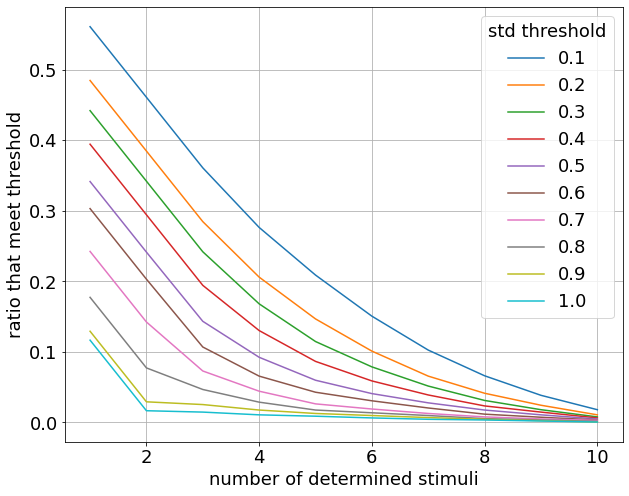

In [232]:
stdevs_thresholds = np.arange(0.1, 1.1, .1)

meets_threshold = []

for stdevs_threshold in stdevs_thresholds:
    _meets_threshold = []
    for number_determined_threshold in range(1,11):
        count = df[(df['stdevs'] > stdevs_threshold) & (df['number_determined'] >= number_determined_threshold)].shape[0]
        _meets_threshold.append(count/df.shape[0])
    meets_threshold.append(_meets_threshold)

plt.figure(figsize = (10,8))
for _meets_threshold in meets_threshold:
    plt.plot(range(1,11), _meets_threshold)
plt.legend([x/10 for x in range(1,11)], title = 'std threshold')
plt.ylabel('ratio that meet threshold')
plt.xlabel('number of determined stimuli')
plt.grid()
plt.show()

In [262]:
stdevs_threshold = .3
number_determined_threshold = 9
meets_threshold = df[(df['stdevs'] > stdevs_threshold) & (df['number_determined'] >= number_determined_threshold)]
print('number that meet threshold:', meets_threshold.shape[0], '/', df.shape[0])

number that meet threshold: 37 / 2060


In [328]:
rNSTs[ind].shape

(10, 1000)

In [331]:
np.nanstd(rNSTs[ind][-2])

0.012484365222151699

stdev: 1.8456852318588968


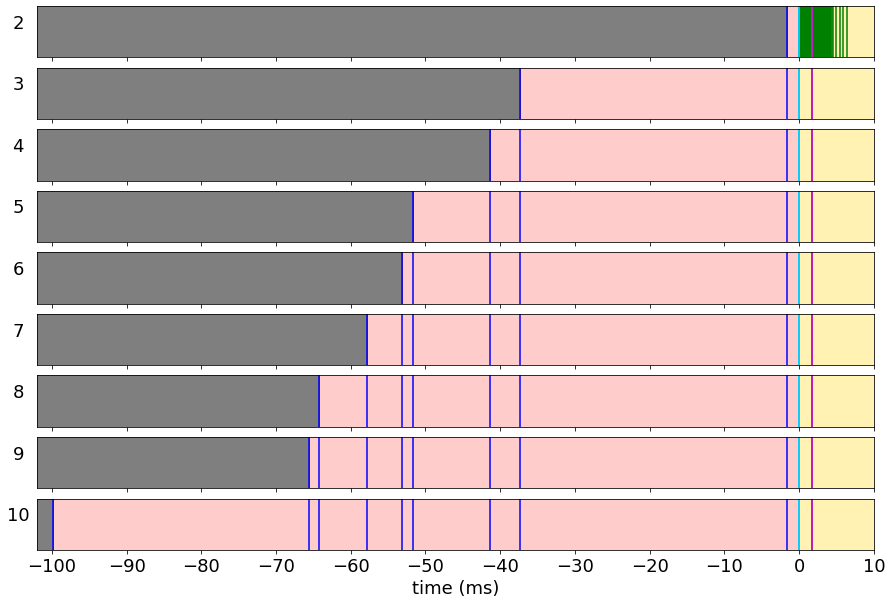

In [323]:
_ind = 4
ind = meets_threshold.index.values[_ind]
print('stdev:',meets_threshold['stdevs'].iloc[_ind])
view_preceding_stims_walk(preceding_stims[ind,:], rNSTs[ind,:,:], rPSTs[ind], list(pivots.values())[ind])

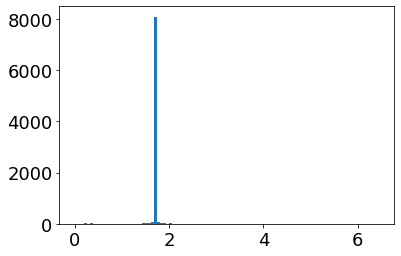

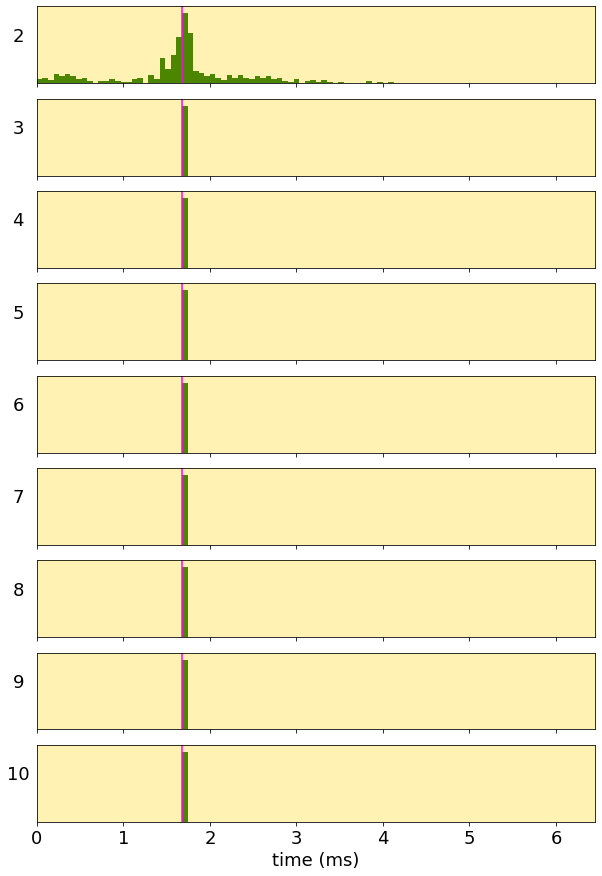

<BarContainer object of 100 artists>

In [324]:
view_NST_hists(preceding_stims[ind,:], rNSTs[ind,:,:], list(pivots.values())[ind])

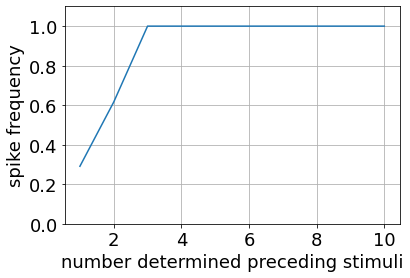

In [325]:
spike_freq = np.isnan(rNSTs[ind,:,:]).sum(axis=1)
spike_freq = np.isnan(rNSTs[ind,:,:]).sum(axis=1)/1000
spike_freq = [1-x for x in spike_freq]
plt.plot(range(1,11), spike_freq)
plt.ylim(0,1.1)
plt.grid()
plt.ylabel('spike frequency')
plt.xlabel('number determined preceding stimuli')
plt.show()

## Back to regular analysis

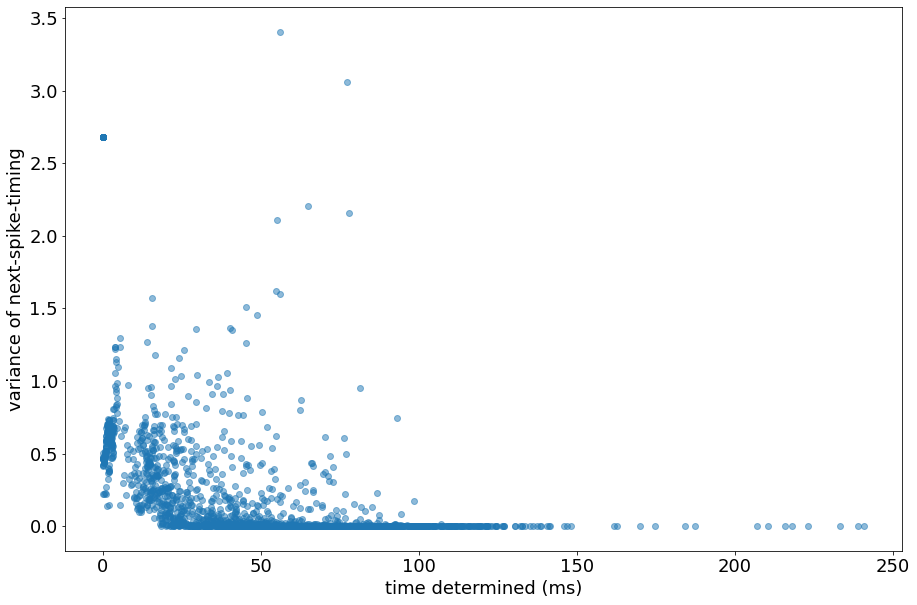

In [269]:
plt.figure(figsize = (15,10))
plt.scatter([td * -1 for td in time_determined], variances, alpha = 0.5)
plt.ylabel('variance of next-spike-timing')
plt.xlabel('time determined (ms)')
plt.show()

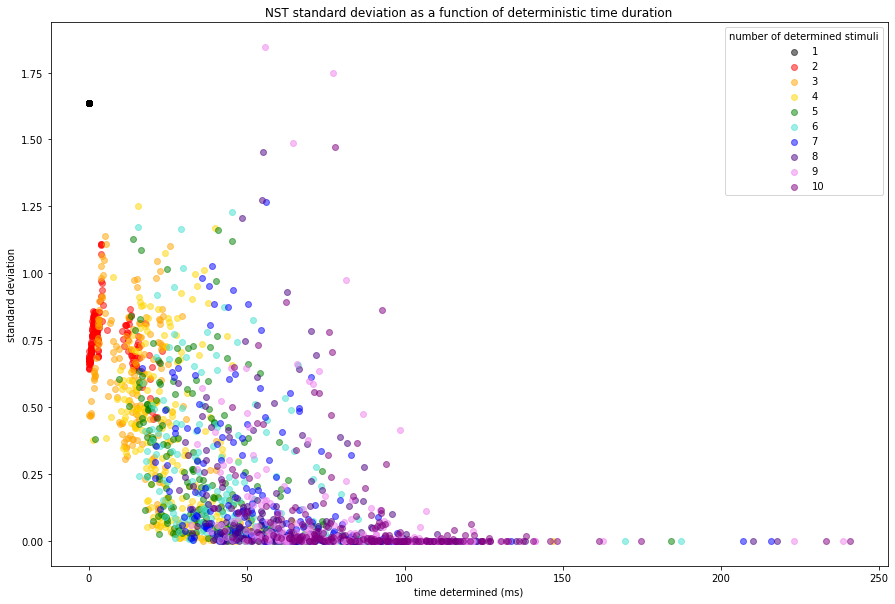

In [66]:
number_determined_np = np.array(number_determined)
time_determined_np = np.array([td * -1 for td in time_determined])
variances_np = np.array(variances)
stdevs_np = np.array(stdevs)
spiking_freq_np = np.array(spiking_freq)

plt.figure(figsize = (15,10))

colors = [
    'black',
    'red',
    'orange',
    'gold',
    'green',
    'turquoise',
    'blue',
    'indigo',
    'violet',
    'purple'
]

for i in range(1,11):
    inds = [int(x) for x in np.argwhere(number_determined_np == i)]
    plt.scatter(time_determined_np[inds], stdevs_np[inds], alpha = 0.5, c = colors[i-1])
plt.title('NST standard deviation as a function of deterministic time duration')
plt.legend(range(1,11), title='number of determined stimuli')
plt.xlabel('time determined (ms)')   
plt.ylabel('standard deviation')
plt.show()

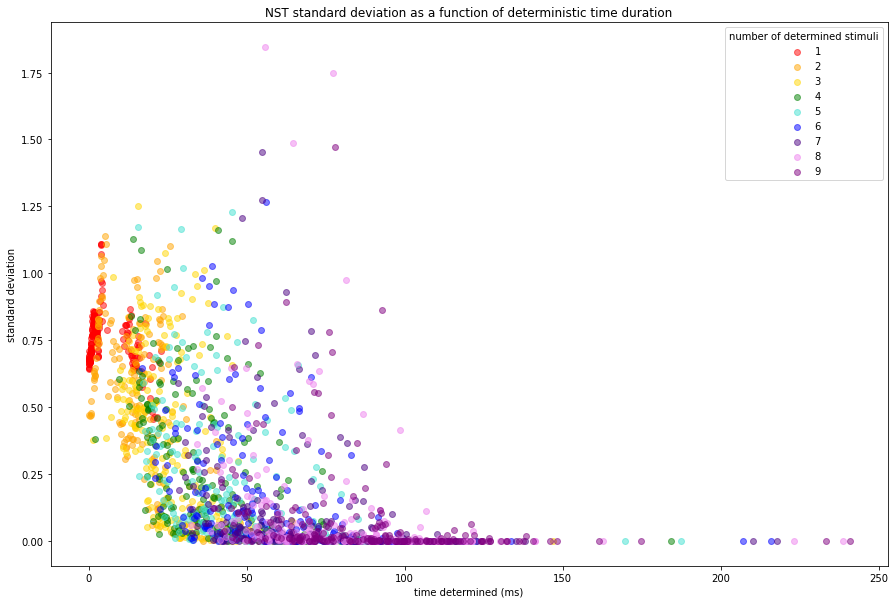

In [71]:
plt.figure(figsize = (15,10))
for i in range(2,11):
    inds = [int(x) for x in np.argwhere(number_determined_np == i)]
    plt.scatter(time_determined_np[inds], stdevs_np[inds], alpha = 0.5, c = colors[i-1])
plt.title('NST standard deviation as a function of deterministic time duration')
plt.legend(range(1,11), title='number of determined stimuli')
plt.xlabel('time determined (ms)')   
plt.ylabel('standard deviation')
plt.show()

In [14]:
number_determined_violin = {i : [] for i in range(1,11)}

for i, n in enumerate(number_determined):
    if variances[i] >= 0:
        number_determined_violin[n].append(variances[i])

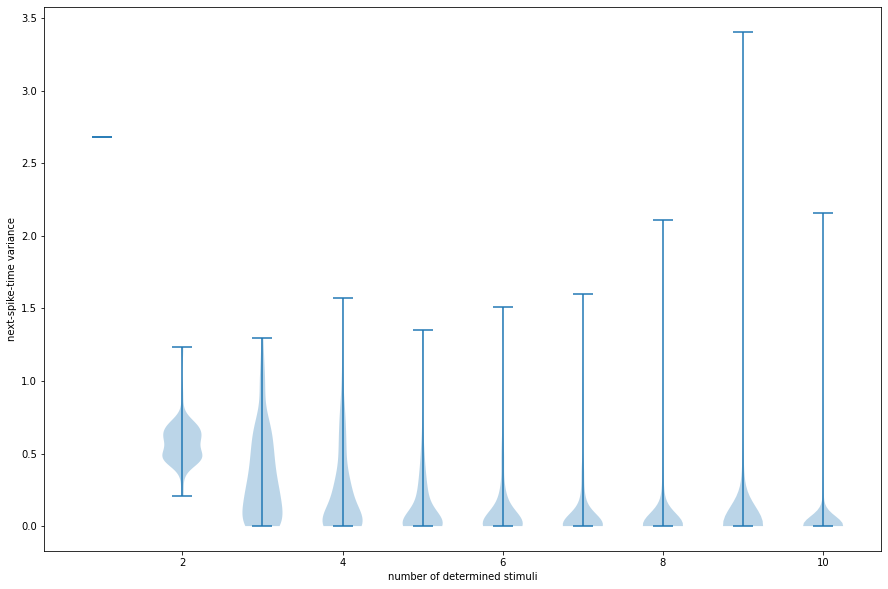

In [15]:
plt.figure(figsize = (15,10))
plt.violinplot([number_determined_violin[i] for i in range(1,11)])
plt.xlabel('number of determined stimuli')
plt.ylabel('next-spike-time variance')
plt.show()

In [16]:
# incorporate spiking during the preceding stimuli analysis

# does some information penetrate an output spike
# is this a hard event horizon

# conditions that constrain the variance
    # interval length
    # output spiking
    # relationship between window length and variance
    

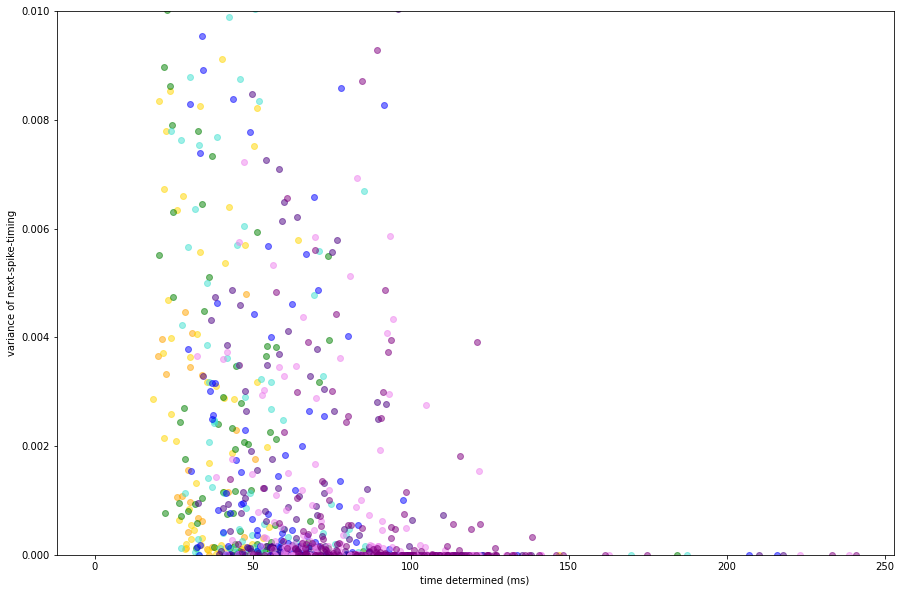

In [17]:
plt.figure(figsize = (15,10))
for i in range(1,11):
    inds = [int(x) for x in np.argwhere(number_determined_np == i)]
    plt.scatter(time_determined_np[inds], variances_np[inds], alpha = 0.5, c = colors[i-1])
plt.ylim(0,0.01)
plt.ylabel('variance of next-spike-timing')
plt.xlabel('time determined (ms)')
plt.show()

Text(0.5, 0, 'amount of determined time for 10 stimuli (ms)')

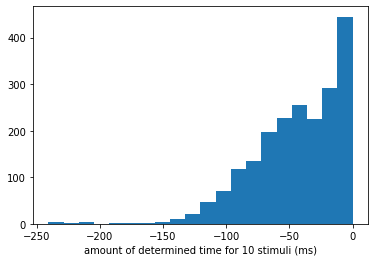

In [18]:
plt.hist(time_determined, bins = 20)
plt.xlabel('amount of determined time for 10 stimuli (ms)')

In [19]:
# plot
# x-axis: bins of time (continuous everything to the right)
# y-axis: fraction of points with variance below a certain threshold

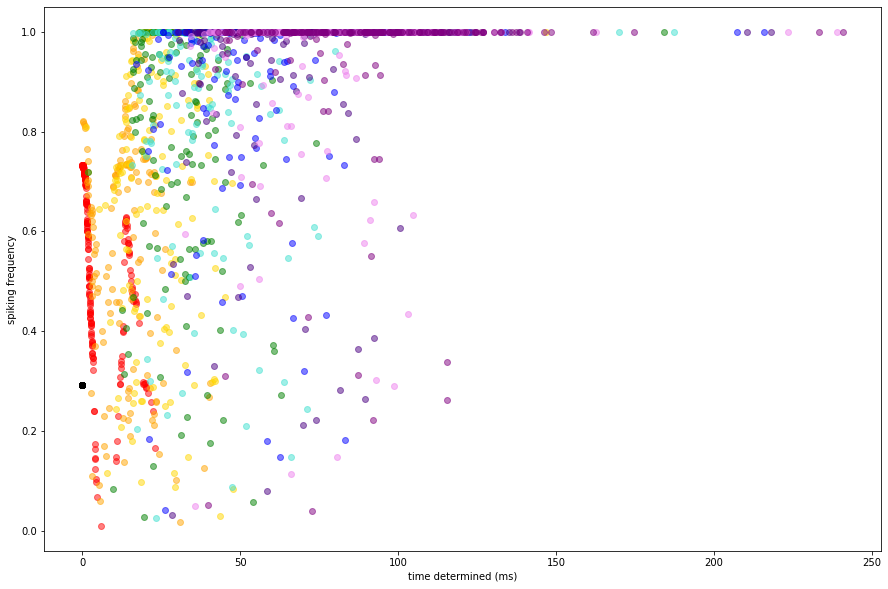

In [20]:
plt.figure(figsize = (15,10))
for i in range(1,11):
    inds = [int(x) for x in np.argwhere(number_determined_np == i)]
    plt.scatter(time_determined_np[inds], spiking_freq_np[inds]/1000, alpha = 0.5, c = colors[i-1])
plt.ylabel('spiking frequency')
plt.xlabel('time determined (ms)')
plt.show()

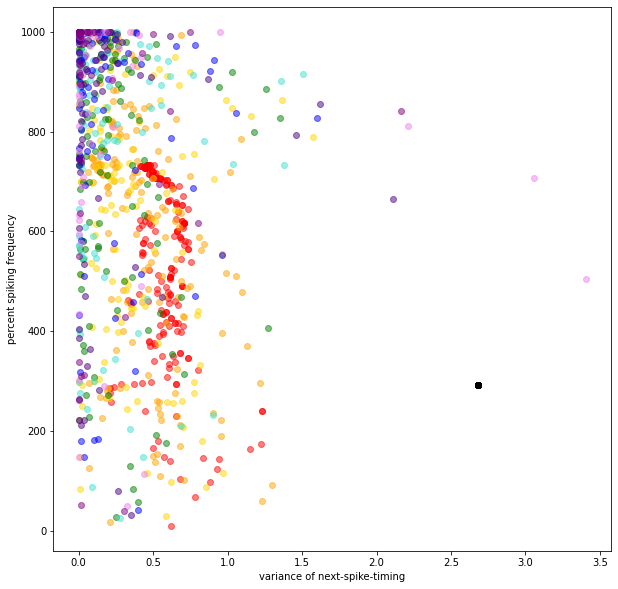

In [21]:
plt.figure(figsize = (10,10))
for i in range(1,11):
    inds = [int(x) for x in np.argwhere(number_determined_np == i)]
    plt.scatter(variances_np[inds], spiking_freq_np[inds], alpha = 0.5, c = colors[i-1])

plt.ylabel('percent spiking frequency')
plt.xlabel('variance of next-spike-timing')
plt.show()

In [22]:
# delta between stimuli to increase in variance

'''
number_determined_np = np.array(number_determined)
time_determined_np = np.array([td * -1 for td in time_determined])
variances_np = np.array(variances)
spiking_freq_np = np.array(spiking_freq)
'''

'\nnumber_determined_np = np.array(number_determined)\ntime_determined_np = np.array([td * -1 for td in time_determined])\nvariances_np = np.array(variances)\nspiking_freq_np = np.array(spiking_freq)\n'

In [23]:
# number_determined, time_i, time_i-1, variance_i, variance_i-1
deltas = []

for i, nd in enumerate(number_determined):
    if nd != 1:        
        deltas.append([
            nd,
            time_determined_np[i],
            time_determined_np[i-1],
            variances_np[i],
            variances_np[i-1]
        ])
deltas = pd.DataFrame(deltas, columns=[
    'number_determined',
    'time_i',
    'time_i-1',
    'variance_i',
    'variance_i-1',
])
deltas.head(n=9)

,number_determined,time_i,time_i-1,variance_i,variance_i-1
0,2,0.650,-0.000,5.160415e-01,2.682263e+00
1,3,16.050,0.650,2.030644e-01,5.160415e-01
2,4,42.550,16.050,6.389314e-03,2.030644e-01
3,5,49.850,42.550,0.000000e+00,6.389314e-03
4,6,50.900,49.850,4.930381e-32,0.000000e+00
5,7,55.675,50.900,4.930381e-32,4.930381e-32
6,8,59.800,55.675,0.000000e+00,4.930381e-32
7,9,71.075,59.800,4.930381e-32,0.000000e+00
8,10,71.425,71.075,4.930381e-32,4.930381e-32


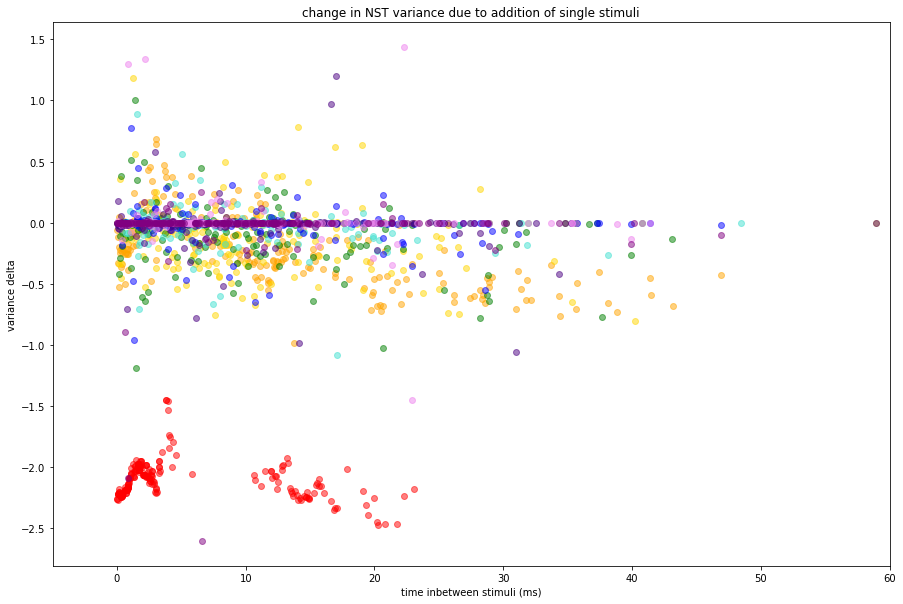

In [24]:
plt.figure(figsize = (15,10))
for i in range(2,11):
    deltas_slice = deltas[deltas['number_determined'] == i]
    
    plt.scatter(
        x = deltas_slice['time_i'] - deltas_slice['time_i-1'],
        y = deltas_slice['variance_i'] - deltas_slice['variance_i-1'],
        c = colors[i-1],
        alpha = 0.5
    )
plt.xlim(-5, 60)
plt.xlabel('time inbetween stimuli (ms)')
plt.ylabel('variance delta')
plt.title('change in NST variance due to addition of single stimuli')
plt.show()

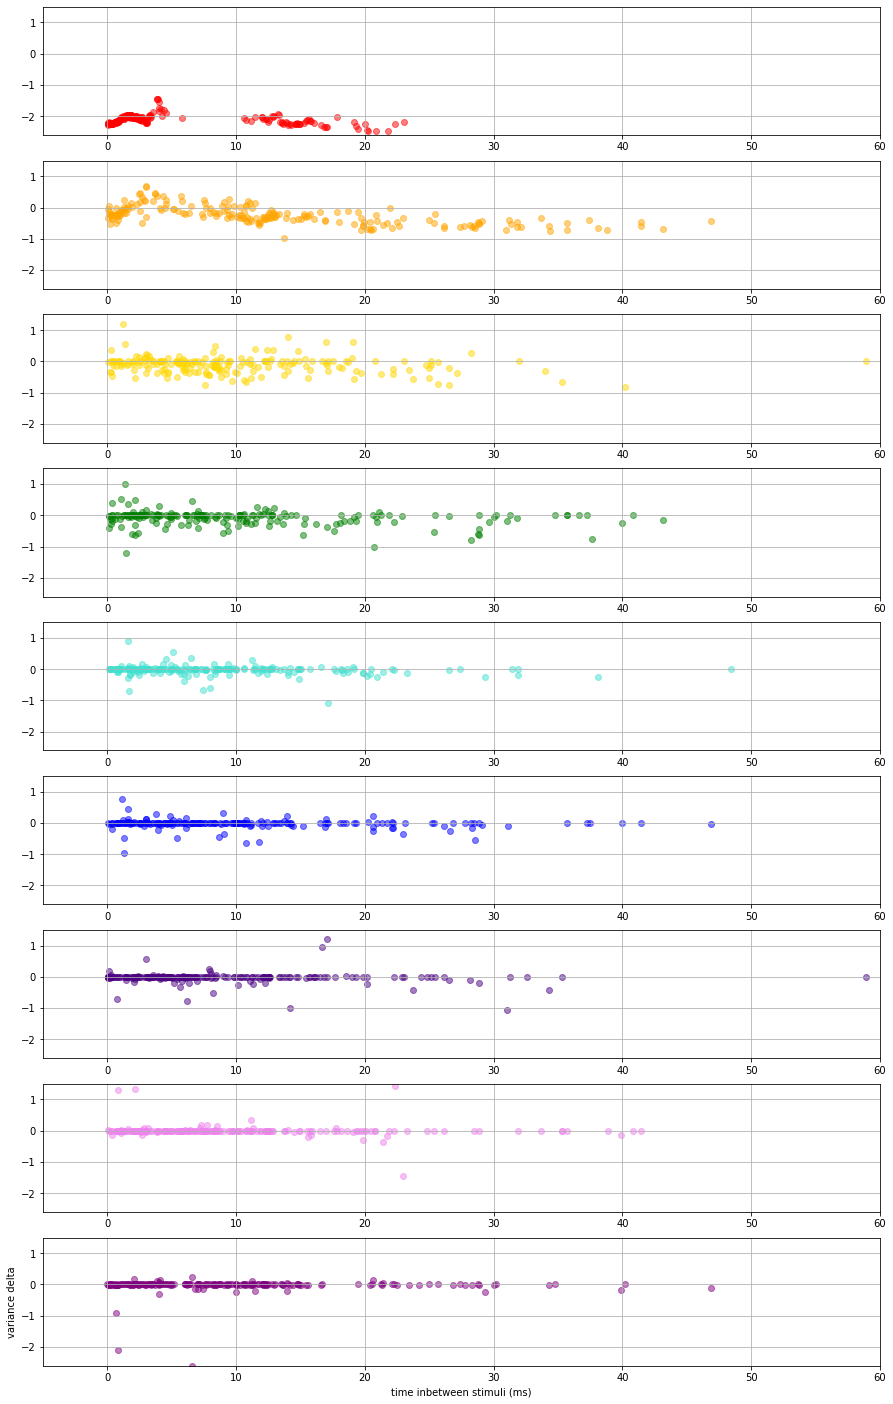

In [25]:
fig, axes = plt.subplots(9,1, figsize = (15,25))

for i in range(2,11):
    deltas_slice = deltas[deltas['number_determined'] == i]
    
    axes[i-2].grid()

    axes[i-2].scatter(
        x = deltas_slice['time_i'] - deltas_slice['time_i-1'],
        y = deltas_slice['variance_i'] - deltas_slice['variance_i-1'],
        c = colors[i-1],
        alpha = 0.5
    )
    axes[i-2].set_ylim((-2.6, 1.5))
    axes[i-2].set_xlim((-5, 60))
plt.xlabel('time inbetween stimuli (ms)')
plt.ylabel('variance delta')
plt.show()

In [31]:
# load stim times
with open('./data/stim_times.txt', 'r') as f:
    stim_times = [float(line.strip()) for line in f.readlines()]
    
stim_times_deltas = []
for i, st in enumerate(stim_times):
    if i > 0:
        stim_times_deltas.append(stim_times[i] - stim_times[i-1])

In [27]:
from scipy.optimize import curve_fit
from scipy import stats

def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y

In [32]:
hist, bins = np.histogram(stim_times_deltas, bins='auto')
x = np.arange(0, len(hist), 1)
x_fit = x + x[1]/2
fit_ = curve_fit(exp_fit, x_fit, hist)
fit_eq = fit_[0][0]*np.exp(-fit_[0][1]*x_fit)

/tmp/ipykernel_32479/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)


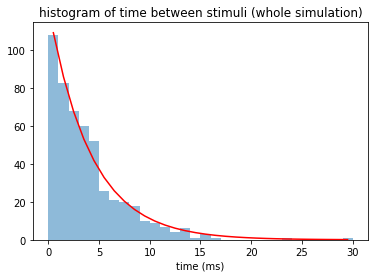

In [33]:
plt.bar(x,hist, alpha = 0.5, align = 'edge', width = 1)
plt.plot(x_fit,fit_eq, color = 'red')
plt.title('histogram of time between stimuli (whole simulation)')
plt.xlabel('time (ms)')
plt.show()

In [ ]:
fig, axes = plt.subplots(9,1, figsize = (10,15))

kstests = []

for i in range(2,11):
    deltas_slice = deltas[deltas['number_determined'] == i]
    deltas_current = deltas_slice['time_i'] - deltas_slice['time_i-1']
    
    _hist = np.histogram(deltas_current, bins=bins)[0]
    x = np.arange(0, len(_hist), 1)
    x_fit = x + x[1]/2
    fit_ = curve_fit(exp_fit, x_fit, _hist)
    fit_eq = fit_[0][0]*np.exp(-fit_[0][1]*x_fit)
    
    axes[i-2].bar(x, _hist, alpha = 0.5, align = 'edge', width = 1)
    axes[i-2].plot(x_fit, fit_eq, color = 'red')
    axes[i-2].set_ylabel('stim\n' + str(i) + ' and ' + str(i-1))
    
    # KS test
    kstests.append(stats.ks_2samp(deltas_current, stim_times_deltas))
    
axes[i-2].set_xlabel('time between stims (ms)')
plt.show()

In [ ]:
kstests

In [ ]:
plt.plot(range(2,11), [ks[1] for ks in kstests], )
plt.yscale('log')
plt.title('nth last stim times KS test')
plt.ylabel('pvalue (log)')
plt.xlabel('nth stim')

plt.show()